# LIME Tutorial for Image Classification

Run all cells in order.

---

In [ ]:
# Google Colab Setup (run this cell first!)
# This cell installs required packages and handles Colab-specific configurations

import sys

# Check if running in Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running in Google Colab - Installing dependencies...")
    !pip install -q torch torchvision lime scikit-image
    print(" Dependencies installed successfully!")
else:
    print("Running locally")

print("Environment ready!")

## What is LIME?

**LIME** explains individual predictions by approximating the complex model locally with an interpretable model (linear model).

### Key Concepts:

1. **Model-Agnostic**: Works with any classifier (neural networks, random forests, etc.)
2. **Local Approximation**: Explains individual predictions, not the entire model
3. **Perturbation-Based**: Generates variations of the input and observes model behavior
4. **Interpretable**: Uses simple models (linear) that humans can understand

### How LIME Works:

```
1. Select an instance to explain (e.g., an image)
2. Generate perturbed samples around this instance
   - For images: turn on/off superpixels (image segments)
3. Get model predictions for all perturbed samples
4. Weight samples by proximity to original instance
5. Fit interpretable model (linear) on weighted dataset
6. Extract feature importance from linear model
```

### Advantages:
- ✅ Works with any model (model-agnostic)
- ✅ Intuitive visual explanations
- ✅ Local fidelity (accurate for specific prediction)

### Disadvantages:
- ❌ Slower (requires many forward passes)
- ❌ Results can vary between runs (random perturbations)
- ❌ Sensitive to hyperparameters (number of samples, segmentation)

---

## 1. Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from lime import lime_image
from skimage.segmentation import mark_boundaries
from pathlib import Path

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.1+cu128
CUDA available: True


## 2. Define the CNN Model

We'll use a simple convolutional neural network for MNIST classification.

In [2]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

print("Model architecture defined successfully!")

Model architecture defined successfully!


## 3. Load MNIST Dataset

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Data directory - works in both Colab and local
data_dir = './data'

# Load datasets
print("Loading MNIST dataset...")
train_dataset = datasets.MNIST(data_dir, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(data_dir, train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Using device: cuda
Loading MNIST dataset...
Training samples: 60000
Test samples: 10000


## 4. Train the Model

We'll train for 3 epochs (quick training for demonstration).

In [4]:
def train_model(model, device, train_loader, epochs=3):
    """Quick training function for demonstration"""
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model.train()
    
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            
            if batch_idx % 100 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

# Initialize and train
print("Initializing model...")
model = SimpleCNN().to(device)

print("\nTraining model (this may take a few minutes)...")
train_model(model, device, train_loader, epochs=3)
print("Training complete!")

Initializing model...

Training model (this may take a few minutes)...


/home/matthewcockayne/.local/lib/python3.10/site-packages/torch/nn/functional.py:1531: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1/3, Batch 0/938, Loss: 2.3091
Epoch 1/3, Batch 100/938, Loss: 0.4796
Epoch 1/3, Batch 100/938, Loss: 0.4796
Epoch 1/3, Batch 200/938, Loss: 0.1297
Epoch 1/3, Batch 200/938, Loss: 0.1297
Epoch 1/3, Batch 300/938, Loss: 0.2604
Epoch 1/3, Batch 300/938, Loss: 0.2604
Epoch 1/3, Batch 400/938, Loss: 0.1953
Epoch 1/3, Batch 400/938, Loss: 0.1953
Epoch 1/3, Batch 500/938, Loss: 0.1132
Epoch 1/3, Batch 500/938, Loss: 0.1132
Epoch 1/3, Batch 600/938, Loss: 0.0426
Epoch 1/3, Batch 600/938, Loss: 0.0426
Epoch 1/3, Batch 700/938, Loss: 0.1187
Epoch 1/3, Batch 700/938, Loss: 0.1187
Epoch 1/3, Batch 800/938, Loss: 0.0434
Epoch 1/3, Batch 800/938, Loss: 0.0434
Epoch 1/3, Batch 900/938, Loss: 0.0470
Epoch 2/3, Batch 0/938, Loss: 0.0750
Epoch 1/3, Batch 900/938, Loss: 0.0470
Epoch 2/3, Batch 0/938, Loss: 0.0750
Epoch 2/3, Batch 100/938, Loss: 0.0732
Epoch 2/3, Batch 100/938, Loss: 0.0732
Epoch 2/3, Batch 200/938, Loss: 0.0575
Epoch 2/3, Batch 200/938, Loss: 0.0575
Epoch 2/3, Batch 300/938, Loss:

## 5. Evaluate Model Accuracy

In [5]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)
        if total >= 1000:
            break

accuracy = 100. * correct / total
print(f"Model Accuracy on test set: {accuracy:.2f}%")

Model Accuracy on test set: 99.00%


## 6. Define LIME Helper Functions

These functions enable LIME to work with our PyTorch model.

In [6]:
def batch_predict(images, model, device):
    """Prediction function for LIME"""
    model.eval()
    batch = torch.stack([torch.from_numpy(img).float() for img in images])
    
    # Handle different input shapes (LIME may pass RGB)
    if len(batch.shape) == 3:  # (batch, H, W)
        batch = batch.unsqueeze(1)  # Add channel dimension
    elif len(batch.shape) == 4 and batch.shape[-1] == 3:  # (batch, H, W, 3) RGB
        batch = batch.mean(dim=-1, keepdim=True)  # Convert to grayscale
        batch = batch.permute(0, 3, 1, 2)  # -> (batch, 1, H, W)
    
    batch = batch.to(device)
    
    with torch.no_grad():
        logits = model(batch)
        probs = F.softmax(logits, dim=1)
    
    return probs.cpu().numpy()


def explain_with_lime(model, image, device, num_samples=1000):
    """Generate LIME explanation for a single image"""
    explainer = lime_image.LimeImageExplainer()
    
    # LIME expects images in HWC format
    image_np = image.squeeze().cpu().numpy()
    
    # Get explanation
    explanation = explainer.explain_instance(
        image_np,
        lambda x: batch_predict(x, model, device),
        top_labels=3,
        hide_color=0,
        num_samples=num_samples
    )
    
    return explanation

print("LIME helper functions defined!")

LIME helper functions defined!


## 7. Generate LIME Explanations

Let's explain predictions for a few test images.

In [ ]:
# Create output directory
output_dir = Path('./results/lime')
output_dir.mkdir(parents=True, exist_ok=True)

num_examples = 3
test_iter = iter(test_loader)

print("Generating LIME explanations...")
print("Note: Each explanation takes ~30 seconds\n")

Generating LIME explanations...
Note: Each explanation takes ~30 seconds



### Example 1

True label: 3, Predicted: 3
Generating LIME explanation...


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].


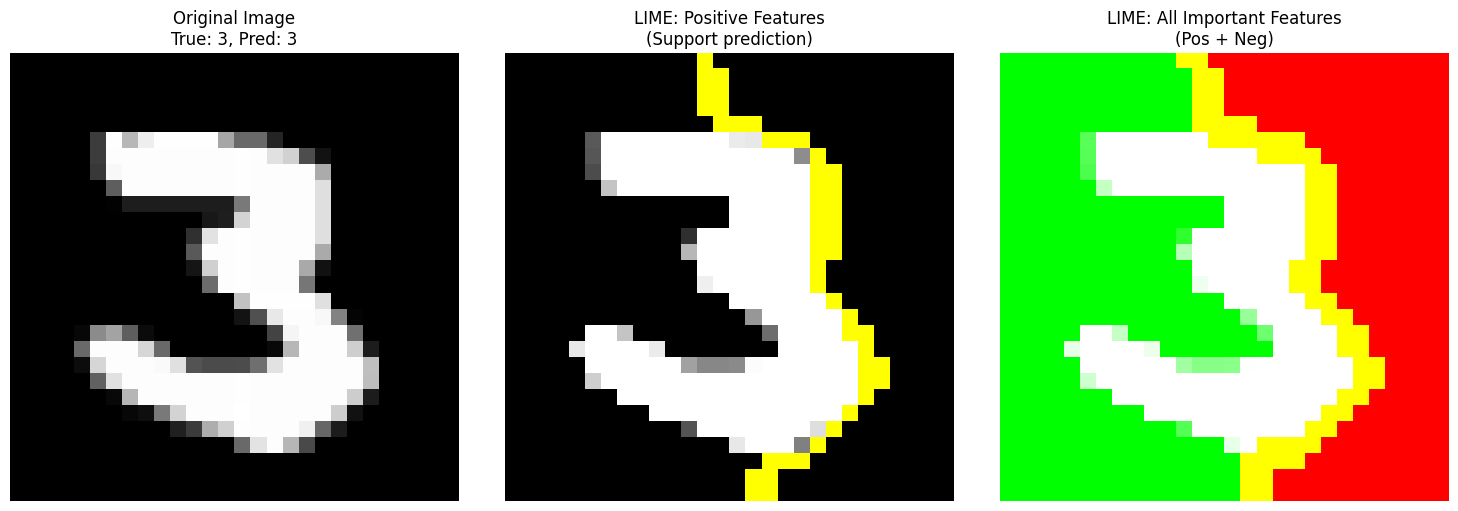

✓ Example 1 complete


In [8]:
# Get test image
image, true_label = next(test_iter)
image = image.to(device)

# Get model prediction
with torch.no_grad():
    output = model(image)
    pred_label = output.argmax(dim=1).item()

print(f"True label: {true_label.item()}, Predicted: {pred_label}")
print("Generating LIME explanation...")

# Generate explanation
explanation = explain_with_lime(model, image, device, num_samples=1000)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original
axes[0].imshow(image.squeeze().cpu().numpy(), cmap='gray')
axes[0].set_title(f'Original Image\nTrue: {true_label.item()}, Pred: {pred_label}')
axes[0].axis('off')

# Positive features
temp, mask = explanation.get_image_and_mask(pred_label, positive_only=True, num_features=5, hide_rest=False)
axes[1].imshow(mark_boundaries(temp, mask))
axes[1].set_title('LIME: Positive Features\n(Support prediction)')
axes[1].axis('off')

# All features
temp, mask = explanation.get_image_and_mask(pred_label, positive_only=False, num_features=10, hide_rest=False)
axes[2].imshow(mark_boundaries(temp, mask))
axes[2].set_title('LIME: All Important Features\n(Pos + Neg)')
axes[2].axis('off')

plt.tight_layout()
plt.savefig(output_dir / 'lime_explanation_example_1.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Example 1 complete")

### Example 2

True label: 4, Predicted: 4
Generating LIME explanation...


/home/matthewcockayne/.local/lib/python3.10/site-packages/torch/nn/functional.py:1531: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].


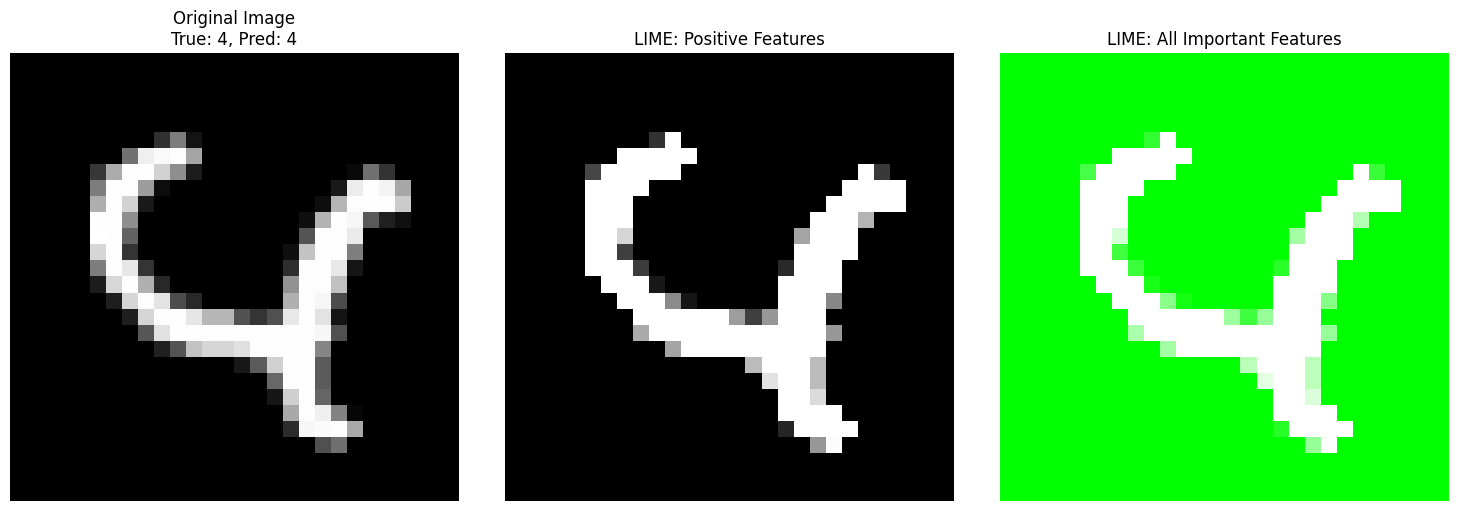

✓ Example 2 complete


In [9]:
# Get test image
image, true_label = next(test_iter)
image = image.to(device)

# Get model prediction
with torch.no_grad():
    output = model(image)
    pred_label = output.argmax(dim=1).item()

print(f"True label: {true_label.item()}, Predicted: {pred_label}")
print("Generating LIME explanation...")

# Generate explanation
explanation = explain_with_lime(model, image, device, num_samples=1000)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image.squeeze().cpu().numpy(), cmap='gray')
axes[0].set_title(f'Original Image\nTrue: {true_label.item()}, Pred: {pred_label}')
axes[0].axis('off')

temp, mask = explanation.get_image_and_mask(pred_label, positive_only=True, num_features=5, hide_rest=False)
axes[1].imshow(mark_boundaries(temp, mask))
axes[1].set_title('LIME: Positive Features')
axes[1].axis('off')

temp, mask = explanation.get_image_and_mask(pred_label, positive_only=False, num_features=10, hide_rest=False)
axes[2].imshow(mark_boundaries(temp, mask))
axes[2].set_title('LIME: All Important Features')
axes[2].axis('off')

plt.tight_layout()
plt.savefig(output_dir / 'lime_explanation_example_2.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Example 2 complete")

### Example 3

/home/matthewcockayne/.local/lib/python3.10/site-packages/torch/nn/functional.py:1531: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


True label: 9, Predicted: 9
Generating LIME explanation...


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].


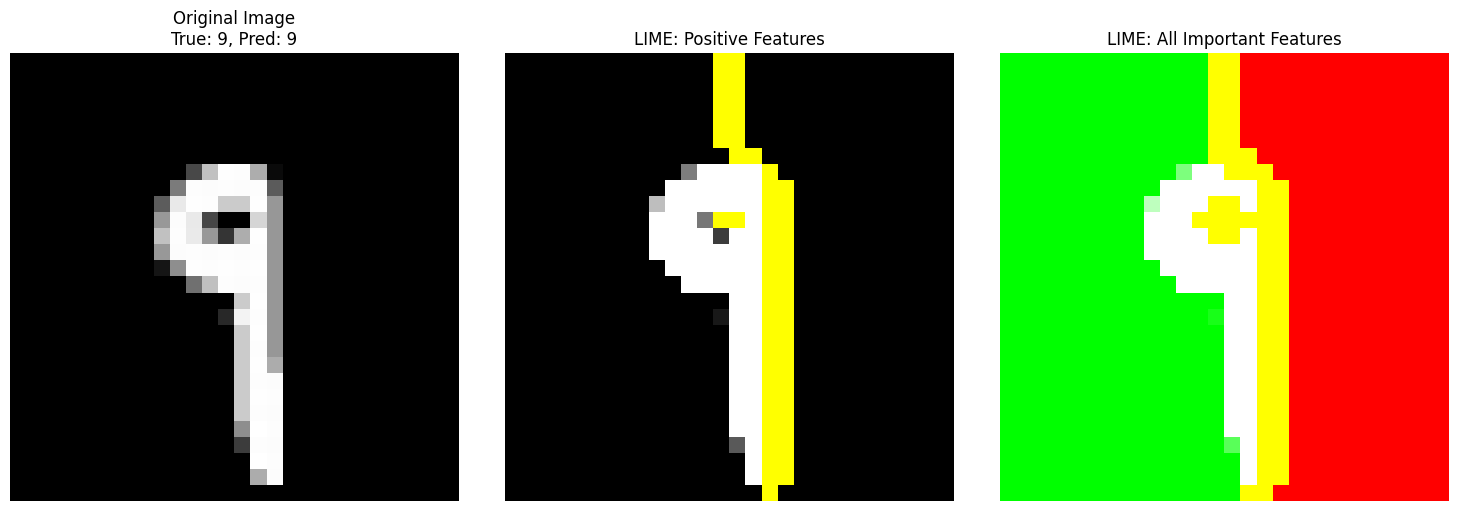

✓ Example 3 complete


In [10]:
# Get test image
image, true_label = next(test_iter)
image = image.to(device)

# Get model prediction
with torch.no_grad():
    output = model(image)
    pred_label = output.argmax(dim=1).item()

print(f"True label: {true_label.item()}, Predicted: {pred_label}")
print("Generating LIME explanation...")

# Generate explanation
explanation = explain_with_lime(model, image, device, num_samples=1000)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image.squeeze().cpu().numpy(), cmap='gray')
axes[0].set_title(f'Original Image\nTrue: {true_label.item()}, Pred: {pred_label}')
axes[0].axis('off')

temp, mask = explanation.get_image_and_mask(pred_label, positive_only=True, num_features=5, hide_rest=False)
axes[1].imshow(mark_boundaries(temp, mask))
axes[1].set_title('LIME: Positive Features')
axes[1].axis('off')

temp, mask = explanation.get_image_and_mask(pred_label, positive_only=False, num_features=10, hide_rest=False)
axes[2].imshow(mark_boundaries(temp, mask))
axes[2].set_title('LIME: All Important Features')
axes[2].axis('off')

plt.tight_layout()
plt.savefig(output_dir / 'lime_explanation_example_3.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Example 3 complete")

## 8. Summary

### Key Takeaways:

1. **LIME approximates complex models locally** using interpretable linear models
2. **Green boundaries** highlight image regions (superpixels) that support the prediction
3. **Positive features** show what the model "looks at" to make its decision
4. **Model-agnostic**: Works with any classifier without needing access to model internals

### When to Use LIME:
- ✅ Debugging model predictions on specific instances
- ✅ Building trust with stakeholders (intuitive explanations)
- ✅ Finding failure modes in your model
- ✅ Works with any model architecture

### Trade-offs:
- **Slower**: Requires many model evaluations (~1000 per explanation)
- **Stochastic**: Results vary slightly between runs
- **Hyperparameter sensitive**: Number of samples, segmentation method affect results

### Next Steps:
- Try **SHAP** for theoretically-grounded attributions
- Try **GradCAM** for faster gradient-based explanations
- Compare multiple methods to get robust insights

---

**All visualizations saved to**: `./results/lime/`